# Introduction to modeling in Gen

This tutorial introduces Gen's built-in modeling language, and illustrates probabilistic inference in Gen using a simple generic inference algorithm.

This tutorial will teach you how to:

- Load the Gen package

- Express a probabilistic model as a generative function in Gen

- Obtain the trace of a generative function, and inspect and visualize it the trace.

- Write a simple inference program based on an importance sampling inference algorithm.

- Interpret the output of the inference program.

- Understand that the amount of computation can affect the accuracy of inferences.

- Compare data predicted using inferred parameters to observed data, as a way of checking the model.

- Write a probabilistic model that uses an infinite tree-structured hypothesis space.

- Write a probabilistic model that invokes general-purpose black-box code.

Note that this tutorial does not cover *inference programming*, in which users implement inference algorithms that are specialized to their probabilistic model. Inference programming is important for getting good results, and will be covered in later tutorials. Also, this tutorial does not exhaustively cover all features of the modeling language -- there are also various features and extensions that provide improved performance that are not covered here.

For Gen reference documentation, see https://probcomp.github.io/Gen/dev/

This tutorial assumes familiarity with Julia. The Julia documentation is at https://docs.julialang.org/en/v1/

## Julia, Gen, and this Jupyter notebook

Gen is a package for the Julia language. The package can be loaded with:

In [549]:
using Gen

Gen programs typically consist of a combination of (i) probabilistic models written in modeling languages and (ii) inference programs written in regular Julia code. Gen provides a built-in modeling language that is itself based on Julia.

This tutorial uses a Jupyter notebook. All cells in the notebook are regular Julia cells. Throughout the tutorial, we will use  that we use semicolons at the end of some cells so that the value of a cell is not printed.

In [6]:
a = 1 + 1

2

In [7]:
a = 1 + 1;

We will also be making use of the PyPlot Julia package:

In [ ]:
using PyPlot

This notebook will make use of Julia symbols. Note that a Julia symbol is different from a Julia string:

In [557]:
typeof(:foo)

Symbol

In [559]:
typeof("foo")

String

## Writing a probabilistic model as a generative function

Probabilistic models represented in Gen as *generative functions*. The simplest way to construct a generative function is by using the built-in modeling DSL. Generative functions written in the built-in modeling DSL are based on Julia function definition syntax, but are prefixed with the `@gen` keyword. The generative function below represents a probabilistic model of a line in the x-y plane, and values of the y-coordinates associated with a given set of x-coordinates.

In [686]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, 0.1), (:y, i))
    end
    return n
end;

The generative function takes as an argument a vector of x-coordinates. We create one below:

In [687]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];

The generative function then samples a random choice representing the slope of a line from a normal distribution with mean 0 and standard deviation 1, and a random choice representing the intercept of a line from a normal distribution with mean 0 and standard deviation 2. In Bayesian statistics terms, these distributions are the *prior distributions* of the slope and intercept respectively. Then, the function samples values for the y-coordinates corresponding to each of the provided x-coordinates Each random choice has a unique *address*. A random choice is assigned an address using the `@addr` keyword. Addresses can be any Julia value. In this program, there are two types of addresses used -- Julia symbols and tuples of symbols and integers.

-------------------------------------------------
### Exercise
List the addresses of all random choices made when applying `line_model` to the vector `xs` defined above.

-------------------------------------------------
### Exercise

Write a generative function that uses the same address twice. Run it to see what happens.

-------------------------------------------------

This generative function returns the number of data points. We can run the function like we run a regular Julia function:

In [688]:
n = line_model(xs)
println(n)

11


It is the random choices made by this generative function that are most important. The random choices are not included in the return value. They are however, included in the *trace* of the generative function. We can run the generative function and obtain its trace using the a method from the Gen API:

In [689]:
(trace, _) = Gen.initialize(line_model, (xs,));

This method takes the function to be executed, and a tuple of arguments to the function, and returns a trace and a second value that we will not be using in this tutorial. When we print the trace, we see that it is a complex data structure.

In [690]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], getfield(Main, Symbol("##821#823"))(), getfield(Main, Symbol("##822#824"))(), Bool[false], false), Trie{Any,Gen.ChoiceRecord}(Dict{Any,Gen.ChoiceRecord}((:y, 7)=>ChoiceRecord{Float64}(0.366805, 1.33376),(:y, 9)=>ChoiceRecord{Float64}(0.858344, 0.597598),(:y, 1)=>ChoiceRecord{Float64}(-0.521729, 1.0343),(:y, 10)=>ChoiceRecord{Float64}(0.791112, 0.78814),(:y, 5)=>ChoiceRecord{Float64}(0.13664, 1.11852),(:y, 4)=>ChoiceRecord{Float64}(0.178788, 1.36586),:intercept=>ChoiceRecord{Float64}(0.231107, -1.61876),(:y, 3)=>ChoiceRecord{Float64}(-0.160446, 0.775326),(:y, 6)=>ChoiceRecord{Float64}(0.282602, 1.25106),(:y, 8)=>ChoiceRecord{Float64}(0.596301, 1.33675),(:y, 11)=>ChoiceRecord{Float64}(0.940287, 0.574106),(:y, 2)=>ChoiceRecord{Float64}(-0.400627, 1.31369),:slope=>ChoiceRecord{Float64}(0.167285, -0.932931)), Dict{Any,Trie{Any,Gen.ChoiceRecord}}()), Trie{Any,G

The trace contains various data about the execution. In particular, in contains the arguments on which the function was run, which are available with an API method:

In [691]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -0.2, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

The trace also contains the value of the random choices, stored in map from addresses to their values. This map is also available through an API method:

In [692]:
println(Gen.get_assmt(trace))

│
├── (:y, 7) : 0.3668047196962769
│
├── (:y, 9) : 0.8583441301176931
│
├── (:y, 1) : -0.5217292576199977
│
├── (:y, 10) : 0.7911120921956044
│
├── (:y, 5) : 0.13663987805087074
│
├── (:y, 4) : 0.17878789009336943
│
├── :intercept : 0.2311065331940578
│
├── (:y, 3) : -0.16044635894085676
│
├── (:y, 6) : 0.28260167802256053
│
├── (:y, 8) : 0.5963008272172851
│
├── (:y, 11) : 0.9402872846562511
│
├── (:y, 2) : -0.400626690268293
│
└── :slope : 0.16728477141317158



The return value is also recorded in the trace:

In [693]:
println(Gen.get_retval(trace));

11


In order to understand the probabilistic behavior of a generative function, it is helpful to be able to visualize the trace of a generative function. Below, we define a function that uses PyPlot to render a trace of the generative function above. The rendering shows the x-y data points and the line that is represented by the slope and intercept choices.

In [771]:
function render_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    slope = assmt[:slope]
    intercept = assmt[:intercept]
    xmin = minimum(xs)
    xmax = maximum(xs)
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [770]:
figure(figsize=(3,3))
render_trace(trace);

UndefVarError: UndefVarError: args not defined

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavoir. The cell below will allow us to render a grid of traces.

In [696]:
function grid(renderer, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;

Now, we generate several traces and render them in a grid

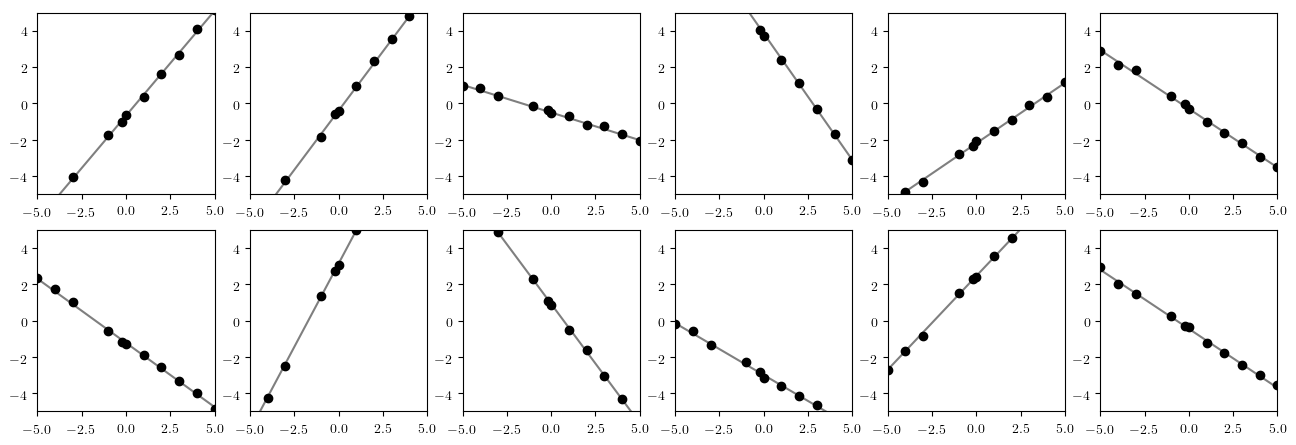

In [697]:
traces = [initialize(line_model, (xs,))[1] for _=1:12]
grid(render_trace, traces)

-------------------------------
### Exercise

Write a model that generates a sine wave of unknown phase, period and amplitude, and then generates y-coordinates from a given vector of x-coordinates by adding noise to the value of the wave at each x-coordinate.
Use a Gamma distribution  (see [`Gen.gamma`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.gamma)). for the prior distributions on the period and amplitude, and a uniform distribution for the phase (see [`Gen.uniform`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.uniform)). Write a function that renders the trace by showing the data set and the sine wave. Visualize a grid of traces and discuss the distribution. Try tweaking the parameters of each of the prior distributions and seeing how the behavior changes.

Hint: There should be three random choices corresponding to the period, amplitude, and phase, and then N random choices, one for each y-coordinate.

### Solution

In [698]:
@gen function sine_model(xs::Vector{Float64})
    n = length(xs)
    period = @addr(gamma(1, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return n
end;

In [699]:
function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    period = assmt[:period]
    amp = assmt[:amp]
    phase = assmt[:phase]
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, amp * sin.(test_xs * (2 * pi / period) .+ phase), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [700]:
traces = [initialize(sine_model, (xs,))[1] for _=1:12];

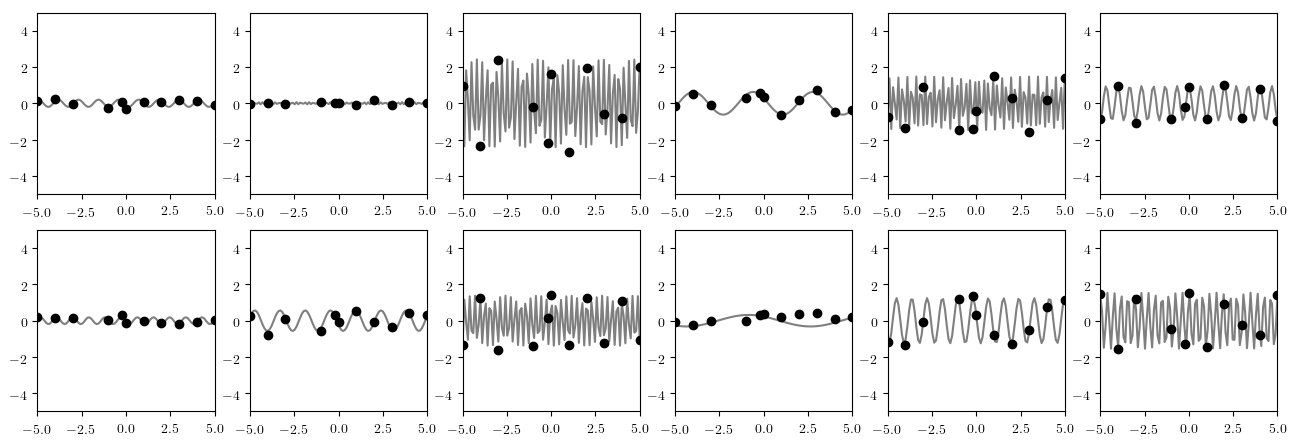

In [701]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

## Doing Bayesian inference

We now will provide a data set of y-coordinates and try to draw inferences about the process that generated the data. We begin with the following data set:

In [1015]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

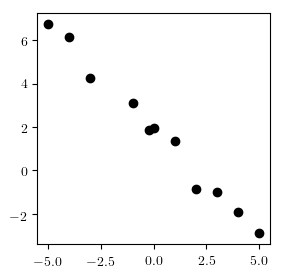

In [863]:
figure(figsize=(3,3))
scatter(xs, ys, color="black");

We will start by assuming that the line model was responsible for generatin the data, and inferring values of the slope and intercept that explain the data.

To do this, we write a simple *inference program* that takes the model we are assuming, the data set, and the amount of computation to perform, and returns a trace of the function that is approximately sampled from the posterior distribution on traces of the function, given the observed data. This inference program is based on a Gen API method `importance_resampling`. Don't worry about the internals of this inference program yet. We will discuss inference programming in later tutorials.

In [704]:
function do_inference(model, xs, ys, amount_of_computation)
    observations = Gen.DynamicAssignment()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

We run the inference program and visualize the result.

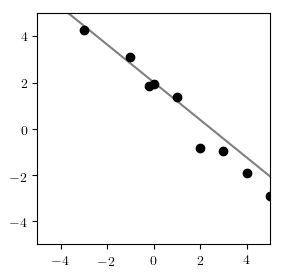

In [705]:
trace = do_inference(line_model, xs, ys, 100)
figure(figsize=(3,3))
render_trace(trace);

We can also visualize many samples in a grid.

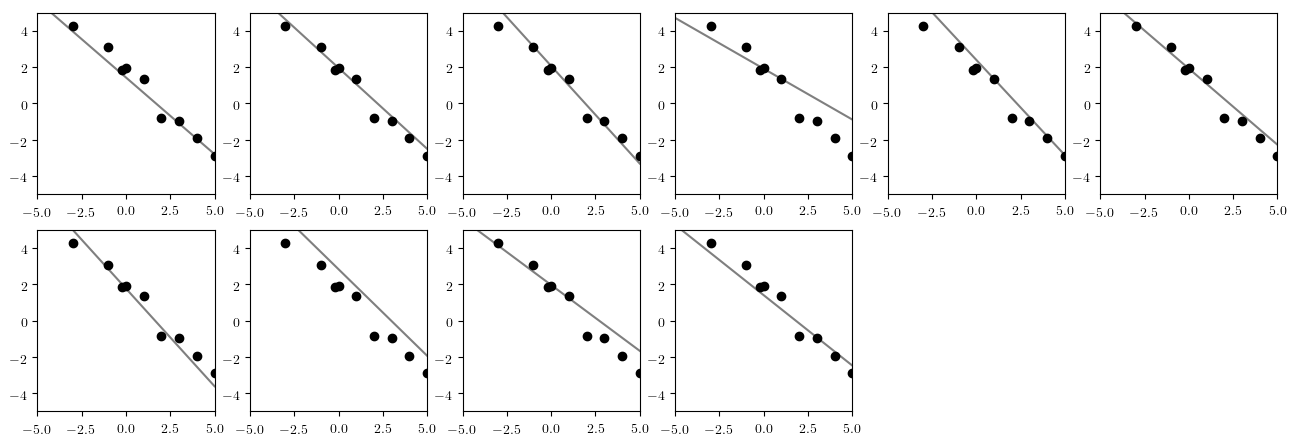

In [706]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

However, in this case we can get a better sense for the variability in the posterior distribution by overlaying the traces. Each trace is going to have the same observed data points, so we only plot those once, based on the values in the first trace.

In [763]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

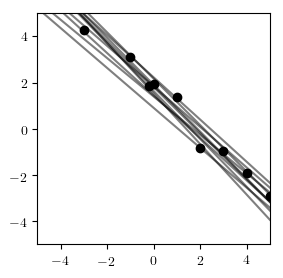

In [764]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
figure(figsize=(3,3))
overlay(render_trace, traces);

--------------

### Exercise

The results above were obtained for `amount_of_computation = 100`. Run the algorithm with this value set to `1`, `10`, and `1000`, etc.  Which value seems like a good tradeoff between accuracy and running time? Discuss.

### Solution

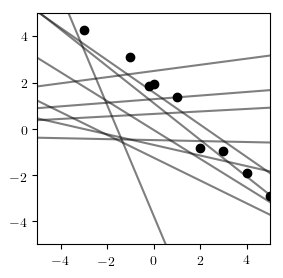

In [709]:
traces = [do_inference(line_model, xs, ys, 1) for _=1:10];
figure(figsize=(3, 3));
overlay(render_trace, traces)

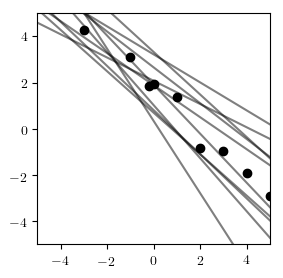

In [710]:
traces = [do_inference(line_model, xs, ys, 10) for _=1:10];
figure(figsize=(3, 3));
overlay(render_trace, traces)

------------------

### Exercise
Consider the following data set.

In [711]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

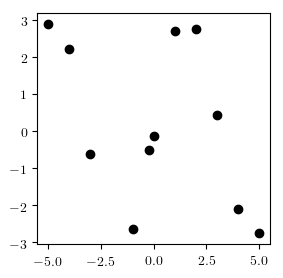

In [712]:
figure(figsize=(3, 3));
scatter(xs, ys_sine, color="black");

Write an inference program that generates traces of the sine wave model that explain this data set. Visualize the resulting distribution of traces. Experiment with a `gamma(1, 1)` and `gamma(5, 1)` prior on the period. Read about the Gamma distribution at https://en.wikipedia.org/wiki/Gamma_distribution. Discuss the results of inference? Do they make sense? How much computation did you need to get good results?

### Solution

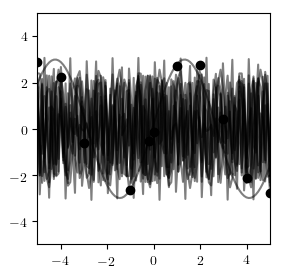

In [713]:
traces = [do_inference(sine_model, xs, ys_sine, 1000) for _=1:10];
figure(figsize=(3,3))
overlay(render_sine_trace, traces)

It is interesting, because any multiple of the "true period" also can explain the data well.

In [714]:
@gen function sine_model_2(xs::Vector{Float64})
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
end;

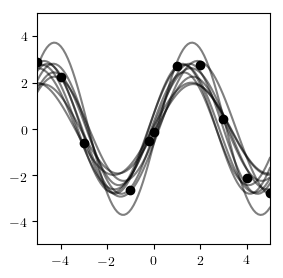

In [834]:
traces = [do_inference(sine_model_2, xs, ys_sine, 1000) for _=1:10];
figure(figsize=(3,3))
overlay(render_sine_trace, traces)

If we reduce the prior probability of very high frequencies, we can get the posterior to concentrate on the "right" period.

## Predicting new data

By providing a third argument to `Gen.initialize`, it is possible to run a generatiev function with the values of certain random choices constrained to given values. The third argument an assignment. For example:

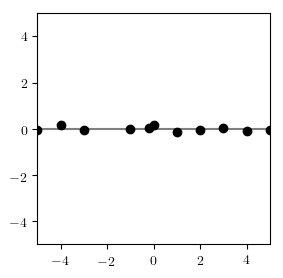

In [947]:
constraints = Gen.DynamicAssignment()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.initialize(line_model, (xs,), constraints)
figure(figsize=(3,3))
render_trace(trace);

Note that the random choices corresponding to the y-coordinates are still made randomly. Run the cell above a few times to verify this.

We will use the ability to run constrained executions of a generative function to predict the value of the y-coordinates at new x-coordinates by running new executions of the model generative function in which the random choices corresponding to the parameters have been constrained to their inferred values.  We have provided a function below that takes a trace, and a vector of new x-coordinates, and returns a vector of predicted y-coordinates corresponding to the x-coordinates in `new_xs`. We have designed this function to work with multiple models, so the set of parameter addresses is an argument.

In [857]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    constraints = Gen.DynamicAssignment()
    assmt = Gen.get_assmt(trace)
    for addr in param_addrs
        if Gen.has_value(assmt, addr)
            constraints[addr] = assmt[addr]
        end
    end
    (new_trace, _) = Gen.initialize(model, (new_xs,), constraints)
    new_assmt = Gen.get_assmt(new_trace)
    ys = [new_assmt[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

The cell below defines a function that first performs inference on an observed data set `(xs, ys)`, and then runs `predict_new_data` to generate predicted y-coordinates. It repeats this process `num_traces` times, and returns a vector of the resulting y-coordinate vectors.

In [948]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [954]:
function plot_predictions(xs, ys, new_xs, pred_ys)
    scatter(xs, ys, color="red")
    for pred_ys_single in pred_ys
        scatter(new_xs, pred_ys_single, color="black", s=1, alpha=0.3)
    end
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

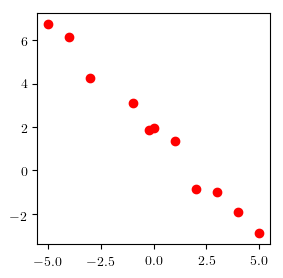

In [927]:
figure(figsize=(3,3))
scatter(xs, ys, color="red");

We will use the inferred values of the parameters to predict y-coordinates for x-coordinates in the interval 5 to 10 from which data was not observed. We will also predict new data within the interval -5 to 5, and we will compare this data to the original observed data. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*. This tutorial does not intend to give a rigorous overview behind techniques for checking the quality of a model, but intends to give high-level intuition.

In [928]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data:

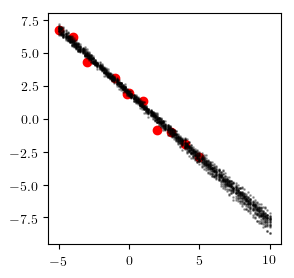

In [955]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with following data set, which has significantly more noise.

In [956]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

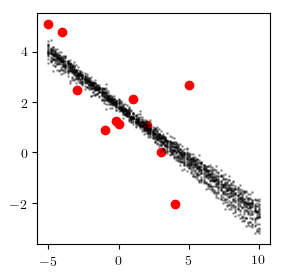

In [957]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

We first write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [958]:
@gen function line_model_2(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

Then, we compare the predictions using inference the unmodified and modified model on the `ys` data set:

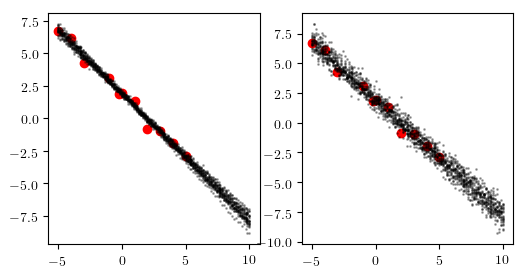

In [964]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(line_model_2, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
plot_predictions(xs, ys, new_xs, pred_ys)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference the unmodified and modified model on the `ys_noisy` data set:

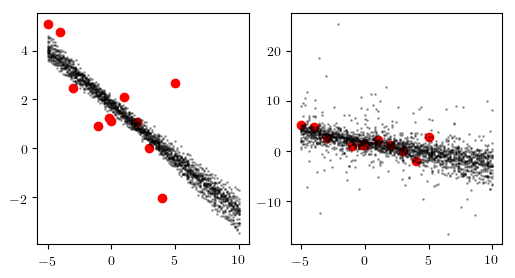

In [963]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(line_model_2, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend

-------------------------
### Exercise

Write a modified version the sine model that makes noise into a random choice. Compare the predicted data with the observed data `infer_and_predict` and `plot_predictions` for the unmodified and modified model, and for the `ys_sine` and `ys_noisy` datasets. Discuss the results. Experiment with the amount of inference computation used. The amount of inference computation will need to be higher for the model with the noise random choice. We have provided you with starter code.

### Solution

In [973]:
@gen function sine_model_3(xs::Vector{Float64})
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), noise), (:y, i))
    end
    return nothing
end;

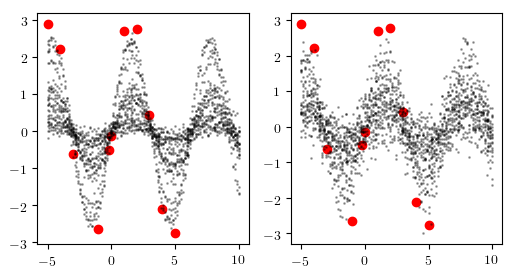

In [974]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(sine_model_2, xs, ys_sine, new_xs, [:period, :amplitude, :phase], 20, 10000)
plot_predictions(xs, ys_sine, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(sine_model_3, xs, ys_sine, new_xs, [:period, :amplitude, :phase, :noise], 20, 50000)
plot_predictions(xs, ys_sine, new_xs, pred_ys)

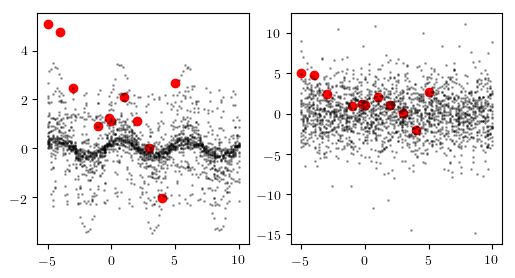

In [972]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(sine_model_2, xs, ys_noisy, new_xs, [:period, :amplitude, :phase], 20, 10000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(sine_model_3, xs, ys_noisy, new_xs, [:period, :amplitude, :phase, :noise], 20, 50000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

## Calling other generative functions

In addition to making random choices, generative functions can invoke other generative functions. To illustrate this, we will write a probabilistic model that combines the line model and the sine model. This model is able to explain data using either model, and which model is chosen will depend on the data. This is called *model selection*.

A generative function can invoke another generative function in two ways -- using `@splice` or using `@addr`. When invoking using `@splice`, the random choices of the callee function are placed in the same address namespace as the caller's random choices. When using `@addr(<call>, <addr>)`, the random choices of the callee are placed under the namespace `<addr>`.

In [983]:
@gen function foo()
    @addr(normal(0, 1), :y)
end

@gen function bar_splice()
    @addr(bernoulli(0.5), :x)
    @splice(foo())
end

@gen function bar_addr()
    @addr(bernoulli(0.5), :x)
    @addr(foo(), :z)
end;

We first show the addresses sampled by `bar_splice`:

In [984]:
(trace, ) = initialize(bar_splice, ())
println(get_assmt(trace))

│
├── :y : 0.383696219396183
│
└── :x : true



And the addresses sampled by `bar_addr`:

In [985]:
(trace, ) = initialize(bar_addr, ())
println(get_assmt(trace))

│
├── :x : false
│
└── :z
    │
    └── :y : -1.2162805113235111



Using `@addr` instead of `@splice` can help avoid address collisions for complex models.

Now, we write a generative function that combies the line and sine models. It makes a Bernoulli random choice (e.g. a coin flip that returns true or false) that determines which of the two models will generate the data.

In [399]:
@gen function combined_model(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        @splice(line_model_2(xs))
    else
        @splice(sine_model_3(xs))
    end
end;

We also write a visualization for a trace of this function:

In [988]:
function render_combined(trace; show_data=true)
    assmt = get_assmt(trace)
    if assmt[:is_line]
        render_trace(trace, show_data=show_data)
    else
        render_sine_trace(trace, show_data=show_data)
    end
end;

We visualize some traces, and see that sometimes it samples linear data and other times sinusoidal data.

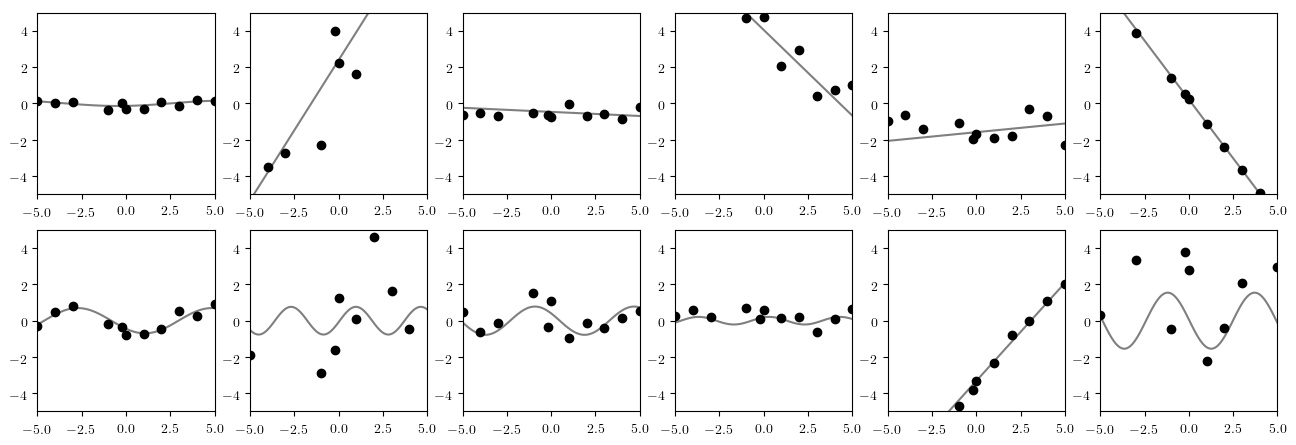

In [989]:
traces = [initialize(combined_model, (xs,))[1] for _=1:12];
grid(render_combined, traces)

We run inference using this combined model on the `ys` data set and the `ys_sine` data set. 

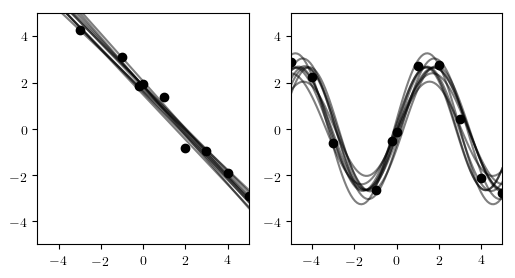

In [990]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_either, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
overlay(render_either, traces)

------
### Exercise 

There is code duplication in `line_model_3` and `sine_model_3`. Refactor the model to reduce code duplication and improve the readability of the code. Re-run the experiment above and confirm that the results are qualitatively the same. You may need to write a new rendering function. Try to avoid introducing code duplication between the model and the rendering code.

Hint: To avoid introducing code duplication between the model and the rendering code, use the return value of the generative function.

### Solution

In [996]:
@gen function line_model_refactored()
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    return (x) -> slope * x + intercept
end;

In [997]:
@gen function sine_model_refactored()
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    return (x) -> amplitude * sin(x * (2 * pi / period) + phase)
end;

In [998]:
@gen function combined_model_refactored(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        mean_fn = @splice(line_model_refactored())
    else
        mean_fn = @splice(sine_model_refactored())
    end
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(mean_fn(x), noise), (:y, i))
    end
    return mean_fn;
end;

In [999]:
function render_either_refactored(trace; show_data=true)
    xs = get_args(trace)[1]
    mean_fn = get_retval(trace)
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, map(mean_fn, test_xs), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

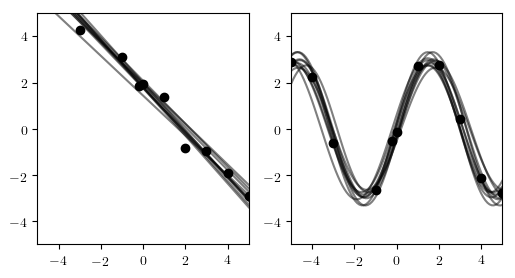

In [1000]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_either, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
overlay(render_either, traces)

-------

### Exercise

Construct a data set for which it is ambiguous whether the line or sine wave model is best. Visualize the inferred traces usingn `render_either` to illustrate the ambiguity. Write a program that takes the data set and returns an estimate of the posterior probability that the data was generated by the sine wave model, and run it on your data set.

Hint: To estimate the posterior probability that the data was generated by the sine wave model, run the inference program many times to compute a large number of traces, and then compute the fraction of those traces in which `:is_line` is false.

### Solution

In [1005]:
ys_ambig = sin.(0.5 * xs);

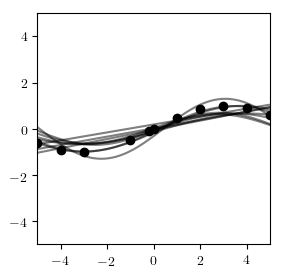

In [1007]:
figure(figsize=(3,3))
traces = [do_inference(combined_model, xs, ys_ambig, 10000) for _=1:10];
overlay(render_either, traces)

In [1011]:
function estimate_prob_sine(xs, ys)
    m = 20
    traces = [do_inference(combined_model, xs, ys, 10000) for _=1:m];
    num_sine = sum(map((t) -> !get_assmt(t)[:is_line], traces))
    return num_sine / m
end;

In [1012]:
println(estimate_prob_sine(xs, ys_ambig))

0.7


In [1016]:
println(estimate_prob_sine(xs, ys))

0.0


In [1014]:
println(estimate_prob_sine(xs, ys_sine))

1.0


## An infinite discrete hypothesis space

illustrate recursion in the dynamic DSL

consider parittions of the [0, 1] line.

In [425]:
struct Interval
    l::Float64
    u::Float64
end

ErrorException: invalid redefinition of constant LeafNode

In [457]:
abstract type Node end
    
struct InternalNode4 <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode4 <: Node
    value::Float64
    interval::Interval
end

In [472]:

@gen function generate_changepts(l::Float64, u::Float64)
    interval = Interval(l, u)
    if @addr(bernoulli(0.7), :isleaf)
        value = @addr(normal(0, 1), :value)
        return LeafNode4(value, interval)
    else
        frac = @addr(beta(2, 2), :frac)
        mid  = l + (u - l) * frac
        left = @addr(generate_changepts(l, mid), :left)
        right = @addr(generate_changepts(mid, u), :right)
        return InternalNode4(left, right, interval)
    end
end;

#@gen function changept_model()
#    l = 0.
#    u = 1.
#    node = @addr(generate_changepts(l, u), :cps)
#    return node
#end;

TODO talk about splice?

In [473]:
function render_node(node::LeafNode4)
    plot([node.interval.l, node.interval.u], [node.value, node.value])
end

function render_node(node::InternalNode4)
    render_node(node.left)
    render_node(node.right)
end

render_node (generic function with 6 methods)

In [474]:
function render_tree_trace(trace)
    node = get_retval(trace)
    render_node(node)
    ax = gca()
    ax[:set_xlim]((0, 1))
    ax[:set_ylim]((-3, 3))
end

render_tree_trace (generic function with 1 method)

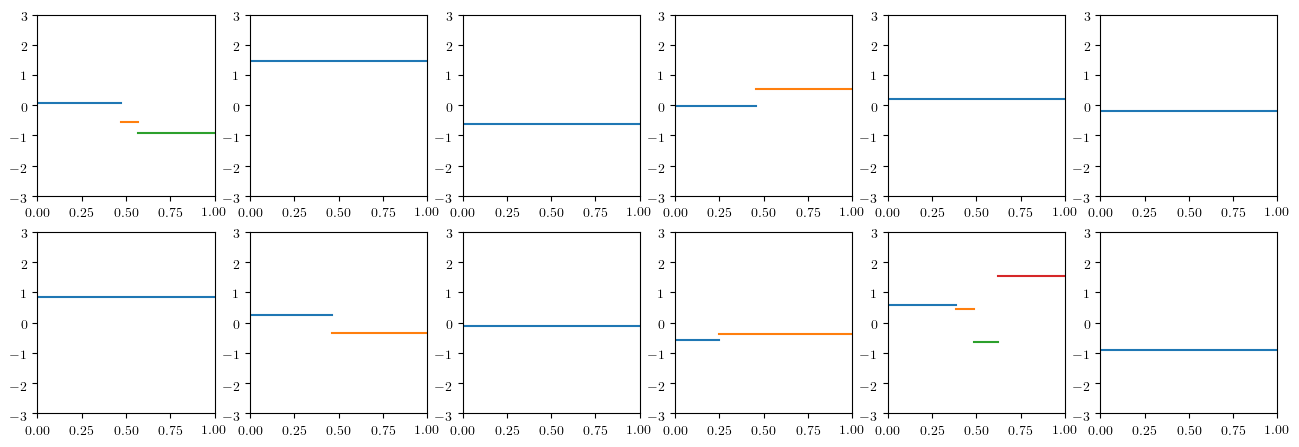

In [479]:
figure(figsize=(16, 8))
for i=1:12
    subplot(3, 6, i)
    (trace, _) = initialize(generate_changepts, (0., 1.));
    render_tree_trace(trace)
end

In [512]:
function get_value_at(x::Float64, node::LeafNode4)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode4)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

@gen function cp_model(xs::Vector{Float64})
    node = @addr(generate_changepts(minimum(xs), maximum(xs)), :tree)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

In [513]:
function render_cp_model_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    node = get_retval(trace)
    render_node(node)
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    ax = gca()
    ax[:set_xlim]((minimum(xs), maximum(xs)))
    ax[:set_ylim]((-3, 3))
end;

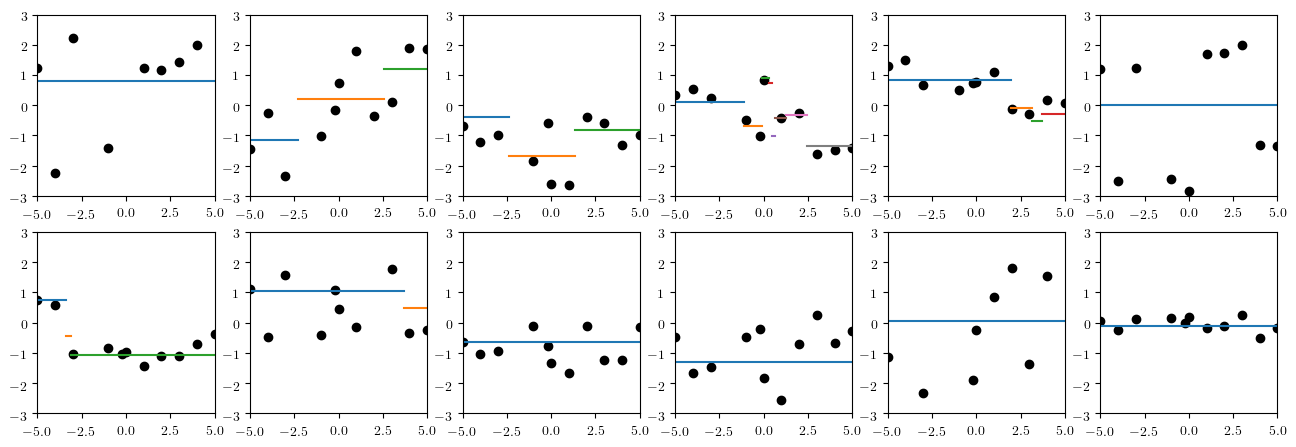

In [514]:
figure(figsize=(16, 8))
for i=1:12
    subplot(3, 6, i)
    (trace, _) = initialize(cp_model, (xs,))
    render_cp_model_trace(trace)
end

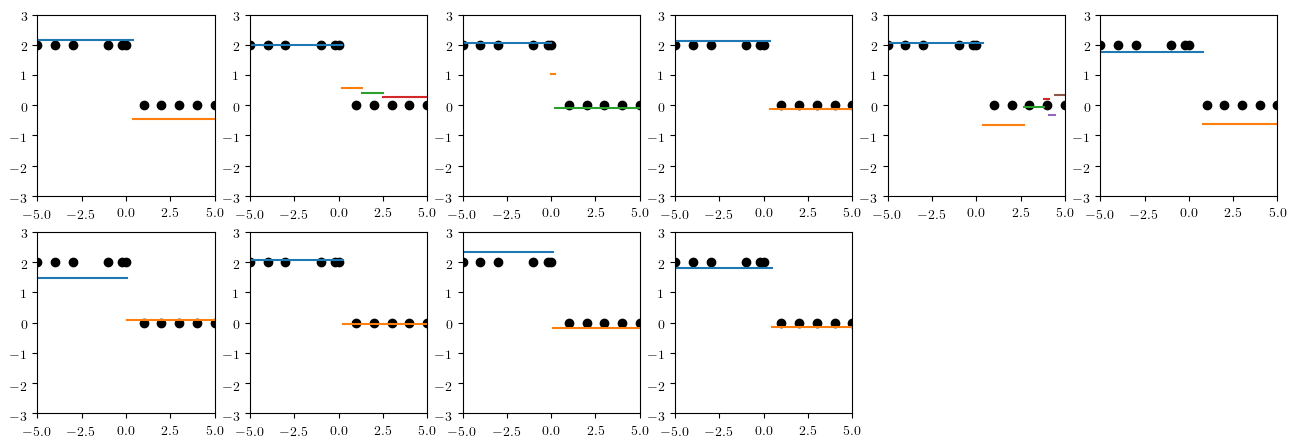

In [528]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];
ys = [x < 0.5 ? 2 : 0 for x in xs]
traces = [do_inference(cp_model, xs, ys, 10000) for _=1:10];
grid(render_cp_model_trace, traces)

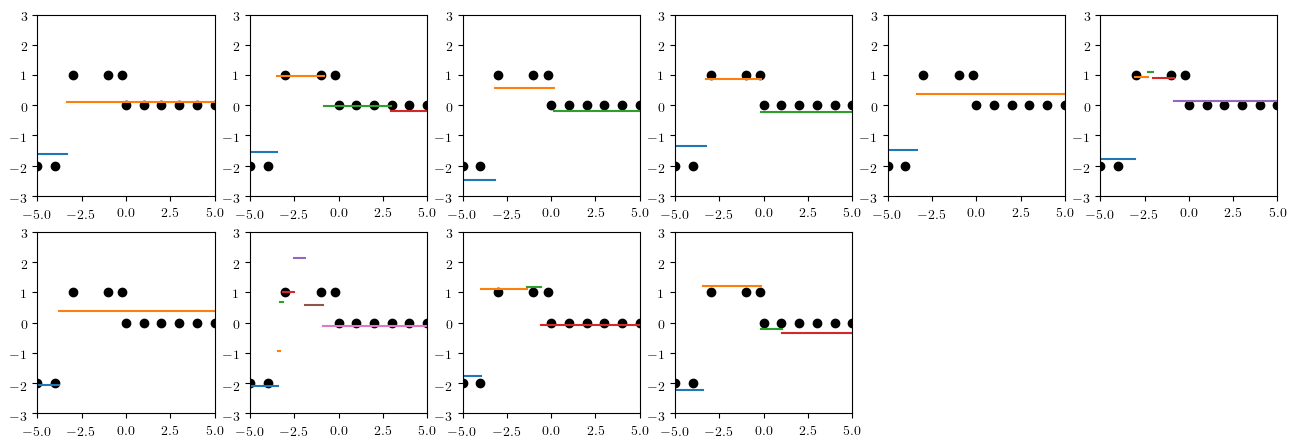

In [532]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];
ys = [x < 0 ? (x < -3 ? -2 : 1) : 0 for x in xs]
traces = [do_inference(cp_model, xs, ys, 100000) for _=1:10];
grid(render_cp_model_trace, traces)

### Exercise
compute the probability that the string is length 1 as a function of the branch probability.

In [ ]:
produce a 

Q: What is the probability of the given tree?
A: multiply the branch bernoulli choices.

idea: sample the changepoints -- create a density estimate of where the changepoints occur.
or ask the probability that there is a changepoint in a particular interval?

## Invoking black-box code

In [534]:
using Pkg;
Pkg.add("Cairo")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %]  46.5 %Fetching: [===========================>             ]  67.4 % Resolving package versions...
 Installed Juno ─ v0.5.4
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [e5e0dc1b] ↑ Juno v0.5.3 ⇒ v0.5.4


In [535]:
Pkg.add("FileIO")
Pkg.add("ImageMagick")
Pkg.add("Compat")
Pkg.add("Images")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


## adding a new distribution

In [536]:
struct NoisyMatrix <: Distribution{Matrix{Float64}} end

const noisy_matrix = NoisyMatrix()

function Gen.logpdf(::NoisyMatrix, x::Matrix{Float64}, mu::Matrix{Float64}, noise::Float64)
    var = noise * noise
    diff = x - mu
    vec = diff[:]
    -(vec' * vec)/ (2.0 * var) - 0.5 * log(2.0 * pi * var)
end

function Gen.random(::NoisyMatrix, mu::Matrix{Float64}, noise::Float64)
    mat = copy(mu)
    (w, h) = size(mu)
    for i=1:w
        for j=1:h
            mat[i, j] = mu[i, j] + randn() * noise
        end
    end
    mat
end

In [ ]:
load(Stream(format"PNG", io))

In [538]:
using ImageMagick

In [545]:
using Cairo
using FileIO
using Compat
using Compat.Base64
using Images
using ImageFiltering

const letters = String["A", "B", "C"]

struct Object
    x::Float64
    y::Float64
    angle::Float64
    fontsize::Int
    letter::String
end

const width = 40
const height = 40
const min_size = 5
const max_size = 10

function render(obj::Object)
    canvas = CairoRGBSurface(width, height)
    cr = CairoContext(canvas)
    Cairo.save(cr)

    # set background color to white
    Cairo.set_source_rgb(cr, 1.0, 1.0, 1.0)
    Cairo.rectangle(cr, 0.0, 0.0, width, height)
    Cairo.fill(cr)
    Cairo.restore(cr)
    Cairo.save(cr)

    # write some letters
    Cairo.set_font_face(cr, "Sans $(obj.fontsize)")
    Cairo.text(cr, obj.x, obj.y, obj.letter, angle=obj.angle)

    # convert to matrix of color values
    buf = IOBuffer()
    Cairo.write_to_png(canvas, buf)
    data = load(Stream(format"PNG", buf))
    println(typeof(data))
    data
end

@gen function model()

    # object prior
    x = @addr(uniform_continuous(0, 1), "x")
    y = @addr(uniform_continuous(0, 1), "y")
    size = @addr(uniform_continuous(0, 1), "size")
    letter = letters[@addr(uniform_discrete(1, length(letters)), "letter")]
    angle = @addr(uniform_continuous(-1, 1), "angle")
    fontsize = min_size + Int(floor((max_size - min_size + 1) * size))
    object = Object(height * x, width * y, angle * 45, fontsize, letter)

    # render
    image = render(object)

    # add speckle
    mat = convert(Matrix{Float64}, image)
    noise = 0.1
    @addr(noisy_matrix(mat, noise), "image")
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], getfield(Main, Symbol("##628#630"))(), getfield(Main, Symbol("##629#631"))(), Bool[], false)

In [547]:
Pkg.rm("ImageMagick")

  Updating `~/.julia/environments/v1.0/Project.toml`
  [6218d12a] - ImageMagick v0.7.1
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [548]:
img = model();

Error encountered while loading nothing.
Fatal error:


ErrorException: error compiling #load_#26: could not load library "/home/marcoct/.julia/packages/ImageMagick/d5KBL/deps/usr/lib/libMagickWand-6.Q16.so"
/lib/x86_64-linux-gnu/libz.so.1: version `ZLIB_1.2.9' not found (required by /home/marcoct/.julia/packages/ImageMagick/d5KBL/deps/usr/lib/libpng16.so.16)